In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from gensim.models import Word2Vec


In [2]:
ratings = pd.read_csv('../data/ml-32m/ratings.csv')
movies= pd.read_csv('../data/ml-32m/movies.csv')

In [3]:
tags = pd.read_csv('../data/ml-32m/tags.csv')

Initial data exploration, looking at the ratings dataset

In [4]:
print(ratings.columns)
user_avg_ratings = ratings.groupby('userId')['rating'].mean()
movie_avg_ratings = ratings.groupby('movieId')['rating'].mean()
print(ratings.head(n=5))
print(user_avg_ratings.head(n=5), movie_avg_ratings.head(n=5))

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
userId
1    3.531915
2    4.269231
3    3.588435
4    2.629630
5    3.272727
Name: rating, dtype: float64 movieId
1    3.897438
2    3.275758
3    3.139447
4    2.845331
5    3.059602
Name: rating, dtype: float64


In [5]:
movies = movies.merge(movie_avg_ratings, on='movieId', how='left', suffixes=('', '_2'))
# One-hot encode the 'genres' column
genre_dummies = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genre_dummies], axis=1)
movies = movies.drop(columns=['genres'])
movies.head(n=5)

,movieId,title,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),3.897438,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),3.275758,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),3.139447,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),2.845331,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),3.059602,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Ensure all tag values are strings before processing
tags['tag'] = tags['tag'].astype(str).str.lower()

# Group tags by movieId and userId, joining tags as comma-separated strings
tags_by_movie = tags.groupby('movieId')['tag'].apply(lambda x: ','.join(x)).reset_index()
tags_by_user = tags.groupby('userId')['tag'].apply(lambda x: ','.join(x)).reset_index()

print(tags_by_movie.head(n=5))
print(tags_by_user.head(n=5))
# Count the unique values in the 'tag' column
unique_tag_count = tags['tag'].nunique()
print(f"Number of unique tags: {unique_tag_count}")
# Cheating a bit here because we know the number of movies and users.
print(f"Number of unique movies with tags: {tags['movieId'].nunique()} / 87585")
print(f"Number of unique users who tagged: {tags['userId'].nunique()} / 200948")

   movieId                                                tag
0        1  children,disney,animation,children,disney,disn...
1        2  robin williams,fantasy,robin williams,time tra...
2        3  comedinha de velhinhos engraãƒâ§ada,comedinha ...
3        4  characters,slurs,based on novel or book,chick ...
4        5  fantasy,pregnancy,remake,family,steve martin,s...
   userId                                                tag
0      22                    kevin kline,misogyny,acrophobia
1      34                           music,weird,steve martin
2      55                           the killls and the score
3      58  bullying,clique,coming of age,gossip,high scho...
4      60                                       sci-fi,space
Number of unique tags: 132172
Number of unique movies with tags: 51323 / 87585
Number of unique users who tagged: 15848 / 200948


2000072
tag
sci-fi                  11437
atmospheric             10088
action                   9337
comedy                   8784
funny                    8088
                        ...  
nadezhda kosheverova        1
chasing a hen               1
cleaning man                1
mikhail shapiro             1
clemence poesy              1
Name: count, Length: 132172, dtype: int64


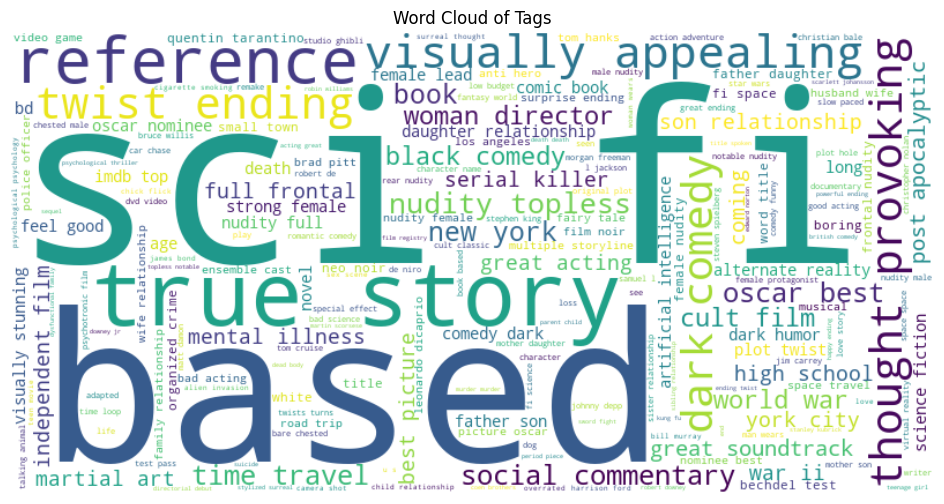

In [7]:
tags['tag'].drop_duplicates() 

all_tags = ' '.join(tags['tag'].dropna())
print(tags['tag'].count())
# Print the count of each unique tag
print(tags['tag'].value_counts())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags')
plt.show()

In [8]:
# Prune infrequent tags. Arbitrarily choosing 50 as a minimum.
tag_counts = tags['tag'].value_counts()
mask = tags['tag'].map(tag_counts) > 50
tags = tags[mask]
print(f"Number of tags after pruning infrequent ones: {tags['tag'].nunique()}")

Number of tags after pruning infrequent ones: 5231


In [9]:
tags_by_movie = tags.groupby('movieId')['tag'].apply(lambda x: ','.join(x)).reset_index()
movies = movies.merge(tags_by_movie, on='movieId', how='left', suffixes=('', '_2'))
movies['tag'].head(n=10)

0    children,disney,animation,children,disney,disn...
1    robin williams,fantasy,robin williams,time tra...
2    midwest,minnesota,funniest movies,sequel,best ...
3    characters,based on novel or book,chick flick,...
4    fantasy,pregnancy,remake,family,steve martin,s...
5    atmospheric,dialogue,tumey's dvds,atmospheric,...
6    great cast,love story,remake,love story,romanc...
7    based on a book,19th century,abandoned house,a...
8    action,jean-claude van damme,can't remember,ac...
9    james bond,tumey's dvds,007,bond,casual sex,es...
Name: tag, dtype: object

In [10]:
# Remove duplicate tags for each movie after grouping
def dedup_tags(tag_str):
    tags = tag_str.split(',')
    # Remove empty strings and deduplicate while preserving order
    seen = set()
    deduped = [t for t in tags if t and not (t in seen or seen.add(t))]
    return ','.join(deduped)

movies['tag'] = movies['tag'].fillna('').apply(dedup_tags)
movies['tag'].head(10)

0    children,disney,animation,pixar,funny,adventur...
1    robin williams,fantasy,time travel,animals,kir...
2    midwest,minnesota,funniest movies,sequel,best ...
3    characters,based on novel or book,chick flick,...
4    fantasy,pregnancy,remake,family,steve martin,a...
5    atmospheric,dialogue,tumey's dvds,realistic ac...
6    great cast,love story,remake,romance,drama,gre...
7    based on a book,19th century,abandoned house,a...
8    action,jean-claude van damme,can't remember,19...
9    james bond,tumey's dvds,007,bond,casual sex,es...
Name: tag, dtype: object

In [11]:
# Get the most frequently occurring tags
tag_counts = tags['tag'].value_counts().reset_index()
tag_counts.columns = ['tag', 'frequency']
# Sort by frequency descending (most frequent first)
tag_counts = tag_counts.sort_values(by='frequency', ascending=False)

# Use the 'tag' column from the movies DataFrame (tags grouped per movie)
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(movies['tag'].fillna(''))

# Get feature names (tags)
tags_features = vectorizer.get_feature_names_out()

# Get the average TF-IDF score for each tag across all movies
avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1  # .A1 flattens the matrix to 1D array

# Create a DataFrame for easy viewing
tfidf_scores_df = pd.DataFrame({'tag': tags_features, 'avg_tfidf': avg_tfidf_scores})
tfidf_scores_df = tfidf_scores_df.sort_values(by='avg_tfidf', ascending=False)
tag_counts = tag_counts.merge(tfidf_scores_df, on='tag', how='left')
print(tag_counts.head(25))

c:\Users\murri\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                   tag  frequency  avg_tfidf
0               sci-fi      11437   0.001532
1          atmospheric      10088   0.001324
2               action       9337   0.002206
3               comedy       8784   0.004980
4                funny       8088   0.002925
5              surreal       7480   0.001681
6   visually appealing       7253   0.000823
7      based on a book       6728   0.003662
8         twist ending       6600   0.000802
9          dark comedy       6153   0.001823
10   thought-provoking       6003   0.000654
11             romance       5961   0.004326
12            dystopia       5713   0.001002
13            violence       5454   0.003471
14      cinematography       5429   0.001297
15              murder       5238   0.006959
16   social commentary       5200   0.001449
17             fantasy       5148   0.001585
18              quirky       4954   0.001098
19            stylized       4948   0.000758
20          psychology       4847   0.000797
21        

In [12]:
# Keep only the 15 tags per movie with the highest tf-idf values
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(','), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(movies['tag'].fillna(''))
tags_features = vectorizer.get_feature_names_out()

def top_n_tfidf_tags(row_idx, n=15):
    row = tfidf_matrix.getrow(row_idx)
    tag_scores = list(zip(tags_features, row.toarray().flatten()))
    # Filter out tags with zero tf-idf
    tag_scores = [(tag, score) for tag, score in tag_scores if score > 0]
    tag_scores.sort(key=lambda x: -x[1])
    top_tags = [tag for tag, score in tag_scores[:n]]
    return ','.join(top_tags)

# movies['tag'] = [top_n_tfidf_tags(i, n=15) for i in range(tfidf_matrix.shape[0])]
movies['tag'].head(10)

c:\Users\murri\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0    children,disney,animation,pixar,funny,adventur...
1    robin williams,fantasy,time travel,animals,kir...
2    midwest,minnesota,funniest movies,sequel,best ...
3    characters,based on novel or book,chick flick,...
4    fantasy,pregnancy,remake,family,steve martin,a...
5    atmospheric,dialogue,tumey's dvds,realistic ac...
6    great cast,love story,remake,romance,drama,gre...
7    based on a book,19th century,abandoned house,a...
8    action,jean-claude van damme,can't remember,19...
9    james bond,tumey's dvds,007,bond,casual sex,es...
Name: tag, dtype: object

In [13]:
nlp = spacy.load("en_core_web_md")
def calculate_similarity(words1, words2):
    doc1 = nlp(" ".join(words1))
    doc2 = nlp(" ".join(words2))
    return doc1.similarity(doc2)
people = {}
def is_person(tag):
    if tag in people:
        return people[tag]
    doc = nlp(tag)
    person = any(ent.label_ == "PERSON" for ent in doc.ents)
    people[tag] = person
    return person

In [14]:
movies['actors'] = movies['tag'].apply(lambda x: [tag for tag in x.split(',') if is_person(tag)])

In [15]:
movies['actors'].value_counts().head(20)

actors
[]                         78248
[betamax]                    567
[gore]                       409
[song]                       191
[ninja]                       66
[gore, grindhouse film]       61
[shakespeare]                 58
[lgbtq]                       57
[bibliothek]                  56
[mindfuck]                    48
[imdb bottom 100]             44
[bisexual]                    43
[grindhouse film]             43
[wolf]                        41
[chick flick]                 40
[charlie chaplin]             39
[god]                         38
[buster keaton]               37
[jackie chan]                 34
[dracula]                     33
Name: count, dtype: int64

Movie Features so far: Genre (One-Hot), AvgUsrRating, Tags, Actors
Looking at the "People" tags we also see things like "God", "Pope", "gore", and "lgbtq". We can create a couple of "extra" genres for things like "Religious" and "lgbtq". We've also seen tags like "sex", so we can create an "NSFW" tag. Author notes are valuable too like "Shakespeare" and "stephen king". We can also identify "Oscar Winning"

In [16]:
movies[['tag','actors']].to_csv('movies_tags_actors.csv', index=False)

In [17]:
# Define some meta-tags for themes not captured by Genre
meta_tags = {
    "religious" : ["pope", "god", "jesus", "bible", "church", "devil", "angel", "heaven", "hell", "satan", "jesus christ", "spiritual", "faith",
                   "demon", "religion"],
    "nsfw" : ["gore", "nudity", "sex", "group sex", "violence", "explicit sex", "gruesome", "erection", "nudity (full frontal - notable)",
              "breasts", "nudity (topless - notable)", "nudity (topless)"],
    "childrens" : ["disney", "disney animated feature", "animated"],
    "oscar_winner" : ["oscar (best supporting actor)" ,"oscar (best actor)","oscar (best directing)","oscar winner: best picture","oscar (best picture)",
                      "oscar (best supporting actress)","oscar (best actress)"],
    "oscar_nominee" : ["oscar nominee: best picture","oscar nominee: best actor","oscar nominee: best actress","oscar nominee: best supporting actor",
                      "oscar nominee: best supporting actress","oscar nominee: best director"],
    "notable" : ["afi 100", "imdb top 250", "national film registry"],
    "genres" : [
        "action", "adventure", "animation", "children's", "comedy", "crime", "documentary", "drama", "fantasy", "film-noir", "horror", "musical", "mystery", "romance", "sci-fi", "thriller", "war", "western", "(no genres listed)"
    ]
}

# Function to extract Oscar wins/nominations from tags, remove them, and increment 'oscars' column
def extract_oscars(tags_str):
    tags = [t.strip() for t in tags_str.split(',') if t.strip()]
    oscars = 0.0
    new_tags = []
    for tag in tags:
        if 'oscar winner' in tag or 'oscar (best' in tag or 'oscar winner:' in tag:
            oscars += 2.0
        elif 'oscar nominee' in tag:
            oscars += 0.5
        else:
            new_tags.append(tag)
    return ','.join(new_tags), oscars

# Function to score religion and nsfw meta tags (do not remove them)
def score_religion_nsfw(tags_str):
    tags = [t.strip() for t in tags_str.split(',') if t.strip()]
    nsfw = sum(1 for tag in tags if tag in meta_tags['nsfw'])
    religion = sum(1 for tag in tags if tag in meta_tags['religious'])
    religion_norm = religion / len(meta_tags['religious']) if len(meta_tags['religious']) > 0 else 0
    return nsfw, religion_norm

# Apply Oscar extraction (removes Oscar tags, updates 'oscars' column)
movies[['tag', 'oscars']] = movies['tag'].fillna('').apply(lambda x: pd.Series(extract_oscars(x)))
movies['oscars'] = movies['oscars'].astype(float)

# Apply religion/nsfw scoring (does not remove tags)
movies[['nsfw', 'religion']] = movies['tag'].fillna('').apply(lambda x: pd.Series(score_religion_nsfw(x)))
movies['nsfw'] = movies['nsfw'].astype(int)
movies['religion'] = movies['religion'].astype(float)

movies[['tag', 'oscars', 'nsfw', 'religion']].sort_values(by="religion", ascending=False).head(10)

,tag,oscars,nsfw,religion
186,"christianity,christopher walken,religion,viggo...",0.0,1,0.600000
1933,"tumey's dvds,jesus,good music,christian,christ...",0.0,2,0.533333
9606,"adapted from:comic,angels,demons,good versus e...",0.0,1,0.533333
9938,"1890s,1910s,1920s,adoption,aging,american,apol...",0.0,0,0.466667
3020,"arnold schwarzenegger,bad cgi,devil,apocalypse...",0.0,4,0.466667
6581,"church,demon,priest,betrayal,dark,human sacrif...",0.0,3,0.466667
3876,"adam sandler,product placement,comedy,world bu...",0.0,0,0.466667
61087,"austria,beautiful scenery,emotional,world war ...",0.0,0,0.400000
3606,"mickey rourke,robert de niro,voodoo,tumey's dv...",0.0,5,0.400000
1583,"al pacino,deal with the devil,keanu reeves,rel...",0.0,5,0.400000


In [18]:
# Function to drop tags that are exactly equal to a genre
def drop_genre_tags(tags_str, genres_list):
    tags = [t.strip() for t in tags_str.split(',') if t.strip()]
    filtered_tags = [tag for tag in tags if tag not in genres_list]
    return ','.join(filtered_tags)

# Apply the function to the movies DataFrame
genres_list = meta_tags['genres']
movies['tag'] = movies['tag'].fillna('').apply(lambda x: drop_genre_tags(x, genres_list))

# Show a sample of the updated tags column
movies['tag'].head(10)

0    children,disney,pixar,funny,classic,friendship...
1    robin williams,time travel,animals,kirsten dun...
2    midwest,minnesota,funniest movies,sequel,best ...
3    characters,based on novel or book,chick flick,...
4    pregnancy,remake,family,steve martin,aging,bab...
5    atmospheric,dialogue,tumey's dvds,realistic ac...
6    great cast,love story,remake,greg kinnear,base...
7    based on a book,19th century,abandoned house,a...
8    jean-claude van damme,can't remember,1990s,act...
9    james bond,tumey's dvds,007,bond,casual sex,es...
Name: tag, dtype: object

In [ ]:
# initialize Word2Vec model
w2v_model = Word2Vec(
    sentences=movies['tag'].apply(lambda x: [tag for tag in x.split(',')]),
    vector_size=150,   # Embedding dimension
    window=5,          # Context window
    workers=4          # Parallel processing
)

# convert tags to sentences for tfidf
tag_strings = movies[['movieId', 'tag']].copy()
tag_strings['tag'] = tag_strings['tag'].fillna('').apply(lambda x: ' '.join(x.split(',')))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['tag'].fillna(''))
feature_names = tfidf_vectorizer.get_feature_names_out()
movie_embeddings = {}

for idx, movie_id in enumerate(tag_strings['movieId']):
    # Get TF-IDF vector for this movie
    tfidf_vector = tfidf_matrix[idx].toarray().flatten()
    
    # Get the tags for this movie
    movie_tags = tag_strings.iloc[idx]['tag'].split()
    
    # Initialize embedding vector
    weighted_embedding = np.zeros(w2v_model.vector_size)
    total_weight = 0
    
    # For each tag, add its weighted embedding
    for tag in movie_tags:
        # Check if tag exists in both Word2Vec and TF-IDF vocabularies
        if tag in w2v_model.wv and tag in feature_names:
            # Get TF-IDF weight
            tfidf_idx = np.where(feature_names == tag)[0]
            if len(tfidf_idx) > 0:
                weight = tfidf_vector[tfidf_idx[0]]
                # Add weighted embedding
                weighted_embedding += w2v_model.wv[tag] * weight
                total_weight += weight
    
    # Normalize by total weight if non-zero
    if total_weight > 0:
        weighted_embedding /= total_weight
    
    movie_embeddings[movie_id] = weighted_embedding

# Convert to DataFrame for easier use
embedding_df = pd.DataFrame.from_dict(movie_embeddings, orient='index')
embedding_df.index.name = 'movieId'
embedding_df.columns = [f'tag_embedding_{i}' for i in range(w2v_model.vector_size)]

# Join with your original movies dataframe
movies = movies.merge(embedding_df, on='movieId')
movies.drop(columns=["(no genres listed)"], inplace=True)
movies.head(n=10)
movies.to_csv('pre_processed_movies.csv', index=False)

In [20]:
movies.head(n=10)


,movieId,title,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,tag_embedding_140,tag_embedding_141,tag_embedding_142,tag_embedding_143,tag_embedding_144,tag_embedding_145,tag_embedding_146,tag_embedding_147,tag_embedding_148,tag_embedding_149
0,1,Toy Story (1995),3.897438,0,1,1,1,1,0,0,...,-0.093803,-0.057039,0.207526,0.032518,0.175041,0.040132,-0.231116,-0.164102,0.364844,0.252300
1,2,Jumanji (1995),3.275758,0,1,0,1,0,0,0,...,-0.121172,-0.035464,0.176433,0.113197,0.257786,0.067913,-0.234630,-0.200351,0.285341,0.311918
2,3,Grumpier Old Men (1995),3.139447,0,0,0,0,1,0,0,...,-0.090220,0.064097,0.250207,-0.224983,0.200484,0.176198,-0.196594,-0.127973,0.421002,-0.043282
3,4,Waiting to Exhale (1995),2.845331,0,0,0,0,1,0,0,...,0.125889,0.096505,-0.075684,-0.230281,0.071152,0.171671,-0.434417,-0.185642,0.462955,-0.007893
4,5,Father of the Bride Part II (1995),3.059602,0,0,0,0,1,0,0,...,-0.020187,0.031701,0.242155,-0.174274,0.090183,0.192281,-0.317475,-0.147519,0.545011,0.082882
5,6,Heat (1995),3.868277,1,0,0,0,0,1,0,...,-0.315640,-0.021297,0.147335,-0.181221,0.107842,0.449548,-0.307090,-0.290121,0.517987,-0.059159
6,7,Sabrina (1995),3.363968,0,0,0,0,1,0,0,...,0.246897,0.061601,0.055242,-0.058007,-0.125252,0.207479,-0.487845,0.232576,0.661399,-0.076686
7,8,Tom and Huck (1995),3.115563,0,1,0,1,0,0,0,...,0.111709,-0.043037,-0.113349,0.206706,0.174380,-0.089802,-0.492294,-0.004098,0.190931,0.185993
8,9,Sudden Death (1995),2.987723,1,0,0,0,0,0,0,...,-0.144958,-0.046259,-0.006850,0.280293,0.294721,0.049623,-0.335201,-0.179820,0.129131,0.169636
9,10,GoldenEye (1995),3.427850,1,1,0,0,0,0,0,...,-0.179929,-0.058152,0.070345,0.251228,0.360655,0.029784,-0.294236,-0.228243,0.126991,0.160706


In [21]:
embedding_df.columns = [f'tag_embedding_{i}' for i in range(w2v_model.vector_size)]
